# Exploring Buywizard Solution Space

A few things we'd like to explore here:
- Some random valid solutions, and what the distribution is
- Can we see some similarities between good solutions and bad ones?
- ...



In [135]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def calc_shipping_cost(n):
    if n <= 4:
        return 1.26
    elif n <= 17:
        return 2.22
    elif n <= 40:
        return 3.38
    else:
        return np.inf

def total_cost(batching, price_mat, separate=False):
    prices = sum([price_mat[i, batching[i]] for i in range(len(batching))])
    _, counts = np.unique(batching, return_counts=True)
    shipping = sum([calc_shipping_cost(cnt) for cnt in counts])
    
    if separate:
        return prices, shipping
    return prices + shipping

def generate_random_batching(price_mat):
    n_cards, n_sellers = price_mat.shape
    metaprod_ids = price_df.index.get_level_values('metaprod_id').unique().to_numpy()
    metaprod_ids = metaprod_ids[~np.isnan(metaprod_ids)]
    
    batching = []
    for i in range(n_cards):
        valid_choices, *_ = np.where((price_mat < np.inf)[i])
        batching.append(np.random.choice(valid_choices))
        
    for metaprod in metaprod_ids:
        nrows = len(price_df.loc[metaprod])
        if nrows > 1:
            drop_prods = random.sample(price_df.loc[metaprod].index.tolist(), nrows - 1)
            price_df.drop(index=drop_prods, level="prod_id", inplace=True)
        
    return np.array(batching)

In [144]:
price_df = pd.read_pickle('price_df.pkl')
print(f"{price_df.shape[0]} articles")
print(f"{price_df.shape[1]} sellers")

333 articles
414 sellers


In [152]:
price_df = price_df[~((price_df < np.inf).sum(axis=1) == 0)]

## Impossibility of Brute Force

We can quickly calculate the total number of possible batchings of our cards. All we need to do is calculate the number of unique sellers per card, and multiply these. Just trying to calculate this number gives us a numerical overflow error, so brute-force clearly won't be an option

In [108]:
np.product([(row < np.inf).sum() for row in price_df.to_numpy()])

0

This is a overflow error, the actual number is pretty large.

# Exploring some random solutions

Here we'll generate some random solutions to the problem, and evaluate the price of these solutions. In order to do that, we'll need to choose a notation for our solutions, and calculate the costs.

In [164]:
random_batching = generate_random_batching(price_df.to_numpy())
total_cost(random_batching, price_df.to_numpy())

174.40999999999997

## Cost vs Shipping/TotalCost

In [165]:
cost, shipping_perc, batches = [], [], []
price_mat = price_df.to_numpy()

for i in tqdm(range(10_000)):
    batch = generate_random_batching(price_mat)
    _, counts = np.unique(batch, return_counts=True)
    batches.append(len(counts))
    p, s = total_cost(batch, price_mat, separate=True)
    cost.append(p + s)
    shipping_perc.append(s/(s+p))

100%|██████████| 10000/10000 [02:35<00:00, 64.50it/s]


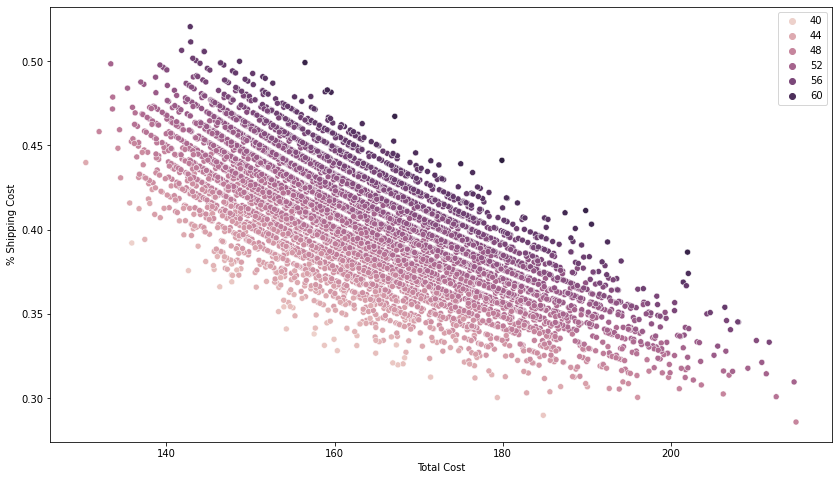

In [166]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(x=cost, y=shipping_perc, hue=batches)
ax.set(xlabel='Total Cost', ylabel='% Shipping Cost')
plt.show()

Some findings from this price matrix:
- Look at those bands! It seems that the number of batches defines these diagonal bands here, which makes some sense. It's free to move cards from one batch to other, as long as we don't cross those 4 or 17 card thresholds for shipping costs.
- It looks like in general having a lower number of batches leads to lower total costs
- The ideal prices do tend to have a lower % shipping costs

In [160]:
min(cost)

556.5199999999999

Although the distribution is more centered towards the lower prices, it's fairly close to normally distributed

# Larger Price Matrix

Although we add more cards here, we're still only looking at powersellers, so the number of possible sellers is still quite low.

In [16]:
price_mat2 = np.load('25x33_price_mat.npy')
price_mat2.shape

(25, 33)

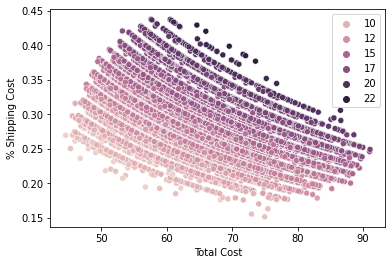

In [17]:
cost, shipping_perc, batches = [], [], []
for i in range(100_000):
    batch = generate_random_batching(price_mat2)
    _, counts = np.unique(batch, return_counts=True)
    batches.append(len(counts))
    p, s = total_cost(batch, price_mat2, separate=True)
    cost.append(p + s)
    shipping_perc.append(s/(s+p))
    
ax = sns.scatterplot(x=cost, y=shipping_perc, hue=batches)
ax.set(xlabel='Total Cost', ylabel='% Shipping Cost')
plt.show()

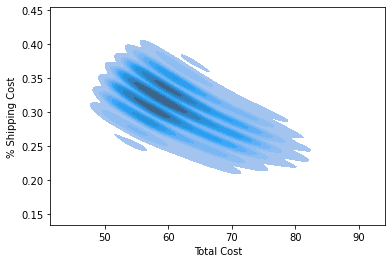

In [18]:
ax = sns.kdeplot(x=cost, y=shipping_perc, fill=True)
ax.set(xlabel='Total Cost', ylabel='% Shipping Cost')
plt.show()

So some findings here:
- More bands (due to more cards, more possible batchings
- The general distribution seems to be similar

# Including Non-commercial Sellers

In [29]:
price_mat3 = np.load("25x231_price_mat.npy")
price_mat3.shape

(25, 231)

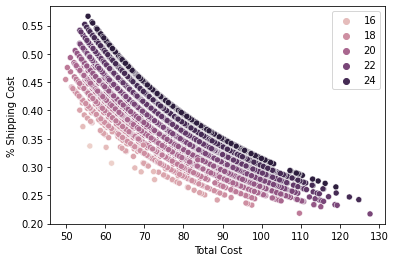

In [34]:
cost, shipping_perc, batches = [], [], []
for i in range(50_000):
    batch = generate_random_batching(price_mat3)
    _, counts = np.unique(batch, return_counts=True)
    batches.append(len(counts))
    p, s = total_cost(batch, price_mat3, separate=True)
    cost.append(p + s)
    shipping_perc.append(s/(s+p))
    
ax = sns.scatterplot(x=cost, y=shipping_perc, hue=batches)
ax.set(xlabel='Total Cost', ylabel='% Shipping Cost')
plt.show()

# Exploring structure of Available Seller/Card Pairs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from main import Batching

In [3]:
price_mat3 = np.load("25x231_price_mat.npy")

In [4]:
batching = Batching(generate_random_batching(price_mat3), price_mat3)

In [5]:
batching

batch([ 15  32  49  73   8  32  53  36  31 109 142  17  58 164  68  90  17 189
 131 209  84  79  63 226  74])

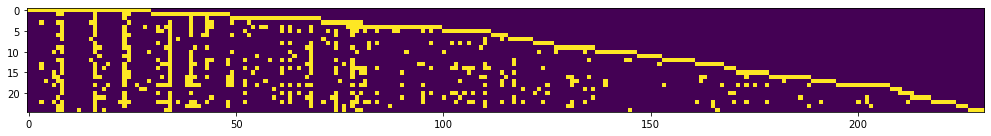

In [6]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(price_mat3 < np.inf)
plt.tight_layout()

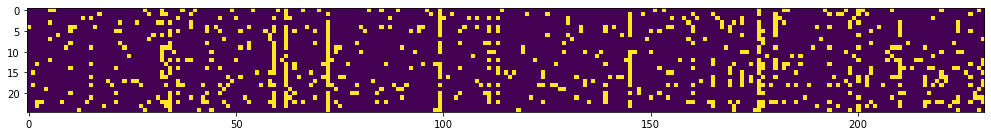

In [7]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(np.random.permutation(price_mat3.T).T < np.inf)
plt.tight_layout()

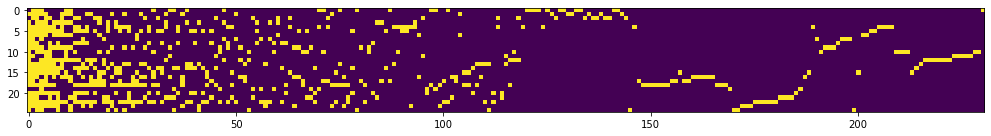

In [8]:
ind = np.argsort((price_mat3 < np.inf).sum(axis=0))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(price_mat3[:, ind[::-1]] < np.inf)
plt.tight_layout()

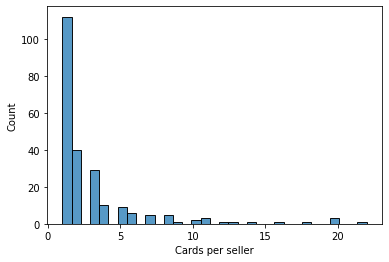

In [59]:
ax = sns.histplot(x = (price_mat3 < np.inf).sum(axis=0))
ax.set(xlabel='Cards per seller')
plt.show()

In [ ]:
# X => number of sellers y => mean price
sns.violinplot(x=)